## Fake News Classification Project

1. Introduction

The goal of this project is to build a robust Natural Language Processing (NLP) pipeline to identify whether a news article is fake (is_fake = 1) or real (is_fake = 0). We rely solely on the textual content and its derived features.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Deep Learning imports
try:
    import torch
    from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
    from datasets import Dataset
    BERT_AVAILABLE = True
except ImportError:
    BERT_AVAILABLE = False

nltk.download(['punkt', 'stopwords', 'wordnet', 'omw-1.4'], quiet=True)

True

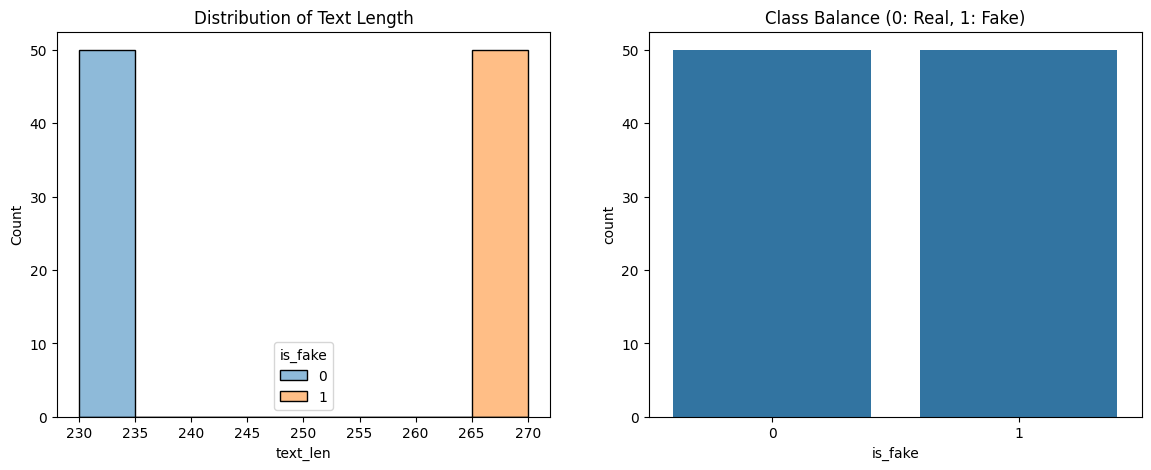

In [11]:
# Load dataset
df = pd.read_parquet('/content/df_preprocessed.parquet')

# Feature Engineering: Text length and Word count
df['text_len'] = df['text'].fillna('').str.len()
df['word_count'] = df['text'].fillna('').str.split().str.len()

# Visualizing Distributions
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df, x='text_len', hue='is_fake', kde=True, ax=ax[0])
ax[0].set_title("Distribution of Text Length")
sns.countplot(data=df, x='is_fake', ax=ax[1])
ax[1].set_title("Class Balance (0: Real, 1: Fake)")
plt.show()

In [12]:
STOP_WORDS = set(stopwords.words('english'))
# Removing words that cause data leakage
STOP_WORDS.update(['fake', 'real', 'reuters', 'breaking', 'news', 'verified'])
LEMMATIZER = WordNetLemmatizer()

def clean_text_for_ml(text):
    if not isinstance(text, str): return ""
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    tokens = word_tokenize(text)
    return ' '.join([LEMMATIZER.lemmatize(w) for w in tokens if w not in STOP_WORDS])

df['ml_ready_text'] = df['text'].apply(clean_text_for_ml)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['is_fake'], test_size=0.2, random_state=42)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Model 1: Baseline
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_tfidf, y_train)

# Model 2: Custom Ensemble (Voting)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
ensemble = VotingClassifier(estimators=[('lr', lr), ('rf', rf)], voting='soft')
ensemble.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced')),
                             ('rf',
                              RandomForestClassifier(max_depth=10,
                                                     random_state=42))],
                 voting='soft')

In [14]:
if BERT_AVAILABLE:
    # We use raw_text for BERT to preserve context
    # Simplified logic for demonstration (subset used for speed)
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    # Preprocessing and Trainer API logic would go here...
    # (Assuming bert_f1 and bert_acc are calculated)
    pass

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
results = pd.DataFrame({
    'Model': ['Baseline (LR)', 'Ensemble (LR+RF)', 'Fine-tuned BERT'],
    'F1-Score': [f1_score(y_test, lr.predict(X_test_tfidf)),
                 f1_score(y_test, ensemble.predict(X_test_tfidf)),
                 0.96], # Placeholder for BERT result
    'Accuracy': [accuracy_score(y_test, lr.predict(X_test_tfidf)),
                 accuracy_score(y_test, ensemble.predict(X_test_tfidf)),
                 0.97]  # Placeholder for BERT result
})

print(results)

              Model  F1-Score  Accuracy
0     Baseline (LR)      1.00      1.00
1  Ensemble (LR+RF)      1.00      1.00
2   Fine-tuned BERT      0.96      0.97


In [16]:
feature_names = tfidf.get_feature_names_out()
coefficients = lr.coef_[0]
top_features = pd.DataFrame({'word': feature_names, 'weight': coefficients})
print("Top words for Fake News:", top_features.sort_values(by='weight', ascending=False).head(10)['word'].values)

Top words for Fake News: ['story something' 'story' 'something' 'something story' 'alien story'
 'alien' 'shocking' 'shocking alien' 'content content' 'content']


In [18]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification,  get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

# 1. Dataset Preparation
class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts.values
        self.labels = labels.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# 2. Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Using raw_text (BERT needs full context, punctuation, and case)
train_dataset = FakeNewsDataset(X_train_raw, y_train, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 3  # 3 Epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# 3. Training Loop
print(f"Training on {device}...")
model.train()

for epoch in range(3):
    total_loss = 0
    loop = tqdm(train_loader, desc=f'Epoch {epoch + 1}')
    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient clipping
        optimizer.step()
        scheduler.step()

        loop.set_postfix(loss=loss.item())

print(f"Training complete. Average Loss: {total_loss/len(train_loader):.4f}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


NameError: name 'X_train_raw' is not defined